In [83]:
import pandas as pd
import numpy as np
import importlib

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.getcwd() + "\\..\\src")
#sys.path.append('c:/Users/User/Documents/User/Work/Admiral/Pipeline_Builder/pipelineconstruction/src')

In [14]:
os.getcwd() + "\\..\\src"

'c:\\Users\\User\\Documents\\User\\Work\\Admiral\\Pipeline_Builder\\pipelineconstruction\\notebooks\\..\\src'

Load the testing working

In [18]:
hp_train = pd.read_csv("..\\data\\raw\\HousePrices.csv")
hp_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


for this notebook we only car about the categorical columns. We will therefore drop the numeric variables to keep the dataset smaller and simpler

In [38]:
hp_cat_train = pd.concat([hp_train["Id"], hp_train.select_dtypes(include=["object"]) ], axis=1)
hp_cat_train.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1461,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,1462,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,1463,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,1464,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,1465,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


We will now plot the count of each of the first 9 categorical variables. Starting with making the dataset long

In [97]:
hp_cat_long = pd.melt(hp_cat_train.iloc[:,0:10], id_vars=['Id'])

and then using seaborn to plot the results

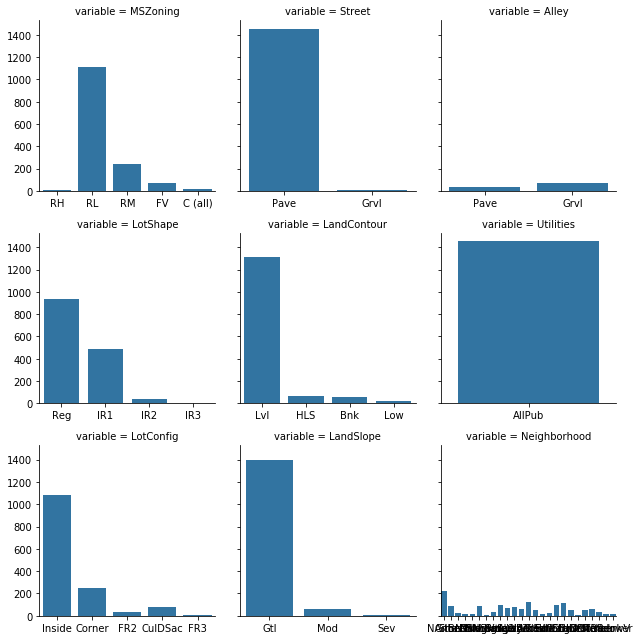

In [98]:
grid = sns.FacetGrid(hp_cat_long, col_wrap=3, col="variable", sharex=False)
grid.map_dataframe(sns.countplot, x="value")

We can see some factors such as neighborhood have many possible values. Others such as street are binary.

We will now subset this dataset into just these variables so the example is smaller

In [99]:
hp_cat_train_work = hp_cat_train.iloc[:,0:10]

# Building the Metadata

We will start by showing the example metadata for this problem

In [265]:
control_sheet = pd.read_csv("..//controls/Housing_Catagorical_ControlSheet.csv")
control_sheet

,FeatureName,TransformedName,Include,Raw,Catagorical,Catagorical_Level_Number,Catagorical_Encoding,Catagorical_Ordering,Missing_Values,Shadow_Col,Impute_Strategy,Impute_Value
0,Id,Id,N,Y,Y,100.0,NaN,NaN,-1; -2,N,NaN,NaN
1,MSZoning,MSZoning,Y,Y,Y,NaN,ordinal,C (all); I; A; FV; RP; RL; RM; RH,NaN,N,constant,Unknown
2,Street,Street,Y,Y,Y,NaN,ordinal,NaN,NaN,N,most_frequent,NaN
3,Alley,Alley,Y,Y,Y,NaN,ordinal,NaN,NaN,N,constant,Unknown
4,LotShape,LotShape,Y,Y,Y,NaN,ordinal,Reg; IR1; IR2; IR3,NaN,N,constant,Unknown
5,LandContour,LandContour,N,Y,Y,NaN,ordinal,Lvl; Bnk; HLS; Low,NaN,N,constant,Unknown
6,Utilities,Utilities,N,Y,Y,NaN,NaN,NaN,NaN,N,constant,Unknown
7,LotConfig,LotConfig,Y,Y,Y,3.0,one_hot,NaN,NaN,N,constant,Unknown
8,LandSlope,LandSlope,Y,Y,Y,NaN,ordinal,Gtl; Mod; Sev,NaN,N,constant,Unknown
9,Neighborhood,Neighborhood,Y,Y,Y,5.0,frequency,NaN,NaN,N,constant,Unknown


We will then import sklearn tools and our custom transformations

In [212]:
# Import standard functions
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [213]:
# Import custom functions
from transformers.IdentifyUnknowns import IdentifyUnknowns
from transformers.FrequencyEncoder import FrequencyEncoder
from transformers.CategoricalCatLimit import CategoricalCatLimit

from transformers.names_from_ColumnTransformer import names_from_ColumnTransformer

this can then be used to build a transformer object

In [344]:
#Check columns exist
needed_cols = ["FeatureName", "TransformedName", "Include", "Raw", "Catagorical", "Catagorical_Level_Number", "Catagorical_Encoding", "Catagorical_Ordering", "Missing_Values", "Shadow_Col", "Impute_Strategy", "Impute_Value"]

for need_col in needed_cols:
    if need_col not in control_sheet.columns:
        raise ValueError(f"{need_col} must be in control_sheet.columns")


# Loop over all columns
for ii in range(0, control_sheet.shape[0]):
    if ii == 0: # create output list
        col_transformers_list = []

    # Check values for boolen columns
    for check_col in ["Include", "Raw", "Shadow_Col", "Catagorical"]:
        if control_sheet.iloc[ii][check_col] not in ["Y", "N", ""]:
            raise ValueError(f'for feature-{in_feat_ii} column-{check_col} must be in ["Y", "N", ""]. Is  {control_sheet.iloc[ii][check_col]}')

    # Only include Features which are to include
    if control_sheet.iloc[ii]["Include"]=="Y" and control_sheet.iloc[ii]["Raw"]=="Y" and control_sheet.iloc[ii]["Catagorical"]=="Y":
        in_feat_ii = control_sheet.iloc[ii]["FeatureName"]
        out_feat_ii = control_sheet.iloc[ii]["TransformedName"]
        
        # Start with a empty list (no transformations)
        feature_union_list = []

        # Removing known missings ---------------------------------------------------
        # Extract string of know missing
        Missing_Values = control_sheet.iloc[ii]["Missing_Values"]
        if Missing_Values == Missing_Values: # check not unknown
            str_unks = [substring.strip() for substring in Missing_Values.split(";")]
        else:
            str_unks = []

        # If there are some values of known missings (e.g. _NA) add transformer to replace them with NAs
        if len(str_unks) > 0:
            feature_union_list.append(("unk_levels", IdentifyUnknowns(unk_levels=[str_unks])))

        Catagorical_Level_Number=1


        # Impute missing values -------------------------------------------------------
        # Impute missing values
        impute_strategy = control_sheet.iloc[ii]["Impute_Strategy"]
        impute_value = control_sheet.iloc[ii]["Impute_Value"]
        
        # Check value of impute_strategy
        if impute_strategy not in ["mean", "median", "most_frequent", "constant"]:
            raise ValueError(f'For feature-{in_feat_ii} Impute_Strategy must be in ["mean", "median", "most_frequent", "constant"] is {impute_strategy}')
        # Check constant value given if needed
        if impute_strategy=="constant" and impute_value!=impute_value:
            raise ValueError(f'For feature-{in_feat_ii} if Impute_Strategy is "constant", impute_value can not be NA.') 

        feature_union_list_no_impute = feature_union_list.copy() # needed to get shadow matrix
        feature_union_list.append(("impute", SimpleImputer(missing_values=np.nan, strategy=impute_strategy, fill_value=impute_value)))


        # Capping the number of levels ---------------------------------------------


        # Encoding ------------------------------------------------------------------

        Catagorical_Encoding = control_sheet.iloc[ii]["Catagorical_Encoding"]
        if Catagorical_Encoding not in ["ordinal", "one_hot", "frequency"]:
            raise  ValueError(f'for feature-{in_feat_ii} Catagorical_Encoding must be in ["ordinal", "one_hot", "frequency"]. Is  {control_sheet.iloc[ii][check_col]}')
        
        # Choice encoding type
        Catagorical_Ordering = control_sheet.iloc[ii]["Catagorical_Ordering"]
        
        if Catagorical_Ordering == Catagorical_Ordering: # check not unknown. If known use as user settings. else use Auto
            input_order = [substring.strip() for substring in Catagorical_Ordering.split(";")] # clean the input string
            
            if Catagorical_Level_Number==Catagorical_Level_Number and not np.isnan(Catagorical_Level_Number): # Add Other if number of levels is capped
                seen = set()
                seen_add = seen.add
                input_order = [x for x in input_order + ["Other"] if not (x in seen or seen_add(x))]

            if impute_strategy=="constant" and impute_value==impute_value: # Add imputed value if not present
                seen = set()
                seen_add = seen.add
                input_order = [x for x in [impute_value] + input_order  if not (x in seen or seen_add(x))]

            str_ordering = [input_order] # Use ordering if given
            
        else:
            str_ordering = "auto" # Use default ordering

        if Catagorical_Encoding == "ordinal": # Use ordinal encoding
            feature_union_list.append(("encode", OrdinalEncoder(categories=str_ordering)))
        elif Catagorical_Encoding == "frequency": # Use frequency encoding
            feature_union_list.append(("encode", FrequencyEncoder(categories=str_ordering, keep_at_start="Unknown", keep_at_end="Other")))
        elif Catagorical_Encoding == "one_hot": # Use frequency encoding
            feature_union_list.append(("encode", OneHotEncoder(categories=str_ordering, drop=None, sparse=False)))

        # Combine all features -------------------------------------------------------
        if control_sheet.iloc[ii]["Shadow_Col"]=="Y":
            # If shadow column needed as second pipeline to give extra column
            pre_col_ii = FeatureUnion([(out_feat_ii, Pipeline(feature_union_list)), \
                                    (out_feat_ii + "_NA", Pipeline([(out_feat_ii + "_imp", Pipeline(feature_union_list_no_impute)), \
                                                                    (out_feat_ii + "_shadow", MissingIndicator(missing_values=["", "Unknown"], features="all"))]) \
                                    ) \
                                    ])
        else:
            # If shadow column not needed use existing pipeline
            pre_col_ii = Pipeline(feature_union_list)
        
        # Add column to transformation list
        col_transformers_list.append((out_feat_ii, pre_col_ii, [in_feat_ii]))

In [363]:
col_transformers_list[6]

('Neighborhood',
 Pipeline(memory=None,
          steps=[('impute',
                  SimpleImputer(add_indicator=False, copy=True,
                                fill_value='Unknown', missing_values=nan,
                                strategy='constant', verbose=0)),
                 ('encode',
                  FrequencyEncoder(categories='auto',
                                   dtype=<class 'numpy.float64'>,
                                   handle_unknown='error',
                                   keep_at_end=[['Other']],
                                   keep_at_start=[['Unknown']],
                                   unknown_value=None))],
          verbose=False),
 ['Neighborhood'])

In [364]:
col_transformers_list[6][1].fit_transform(hp_cat_train_work[["Neighborhood"]])

array([[ 1.],
       [ 1.],
       [ 7.],
       ...,
       [10.],
       [10.],
       [10.]])

In [349]:
col_transformers_list[6][1].fit_transform(hp_cat_train_work[["Neighborhood"]])

array([[ 1.],
       [ 1.],
       [ 7.],
       ...,
       [10.],
       [10.],
       [10.]])

In [354]:
col_transformers_list[0:2]

[('MSZoning',
  Pipeline(memory=None,
           steps=[('impute',
                   SimpleImputer(add_indicator=False, copy=True,
                                 fill_value='Unknown', missing_values=nan,
                                 strategy='constant', verbose=0)),
                  ('encode',
                   OrdinalEncoder(categories=[['Unknown', 'C (all)', 'I', 'A',
                                               'FV', 'RP', 'RL', 'RM', 'RH',
                                               'Other']],
                                  dtype=<class 'numpy.float64'>))],
           verbose=False),
  ['MSZoning']),
 ('Street',
  Pipeline(memory=None,
           steps=[('impute',
                   SimpleImputer(add_indicator=False, copy=True, fill_value=nan,
                                 missing_values=nan, strategy='most_frequent',
                                 verbose=0)),
                  ('encode',
                   OrdinalEncoder(categories='auto',
                  

In [356]:
col_tran = ColumnTransformer(col_transformers_list)
X_t = col_tran.fit_transform(hp_cat_train_work)

In [357]:
X_t_df = pd.DataFrame(X_t, columns=names_from_ColumnTransformer(col_tran))
X_t_df.head()

,MSZoning,Street,Alley,LotShape,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope,Neighborhood
0,8.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,6.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,6.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0
3,6.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0
4,6.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,17.0


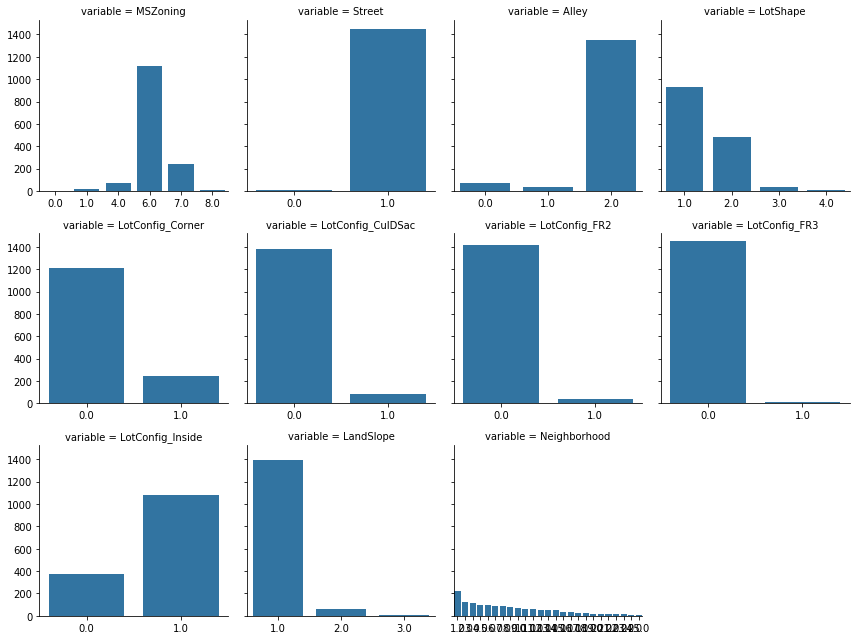

In [362]:
X_t_id = pd.concat([hp_train["Id"], X_t_df ], axis=1)
X_t_long = pd.melt(X_t_id, id_vars=['Id'])
grid = sns.FacetGrid(X_t_long, col_wrap=4, col="variable", sharex=False)
grid.map_dataframe(sns.countplot, x="value")